# Filter 

## Filtering 개요
- 영상에서 필요한 정보만 통과시키고 필요없는 정보는 걸러내는 작업을 말한다.
- N x N행렬을 영상과 Convolution연산(Correlation연산)을 하여 처리한다.
    - 영상과 연산하는 N x N 행렬을 커널(Kernel), 필터(filter), 마스크(Mask), 윈도우(Window)라고 한다.
    - Convolution연산
        - Filter를 영상을 이동하면서 같은 index의 값끼리 곱한뒤 다 더한다. 
        ![conv](figures/conv.gif)        
        
    - 최외곽처리는 바깥에 가상의 픽셀들이 있다고 생각하고 거기에 임의의 값을 채워 계산한다. 
        - 가상의 바깥픽셀을 **Padding**이라고 한다.
        - 바깥픽셀을 채우는 방법
            - BORDER_CONSTANT : 같은 값으로 채운다. 보통 0으로 채움   000|abcd|000
            - BORDER_REPLICATE: 외곽에 있는 값으로 채운다. aaa|abcd|ddd
            - BORDER_REFLECT: 거울에 반사되는 형식으로 채운다. cba|abcd|dcb
            - BORDER_REFLECT_101: (OpenCV 기본방식)BORDER_REFLECT와 같은 형식인데 가장 외곽의 값은 반사시키지 않는다. dcb|abcd|cba
    - N x N 행렬이 어떤 값을 가지고 있느냐에 따라 다양한 영상처리가 가능하다.
        - Bluring: 영상을 부드럽게 만들기
        - Shapening: 영상을 날카롭게 만들기
        - 엣지 검출
        - Noise 제거
    - 다양한 형태의 Kernel이 있으나 보통 3 x 3 행렬을 많이 쓴다.
    
![image.png](figures/anchor.png)
        
- **Anchor(고정점)**: 영상에서 Filtering을 하려는 지점을 가리키는 필터의 중앙점을 사용한다.
- **Receptive Field(수용장)**: 결과 픽셀에 영향을 주는 원본 이미지의 영역

### 기본적인 2차원 Filter계산
- `cv2.filter2D(src, ddepth, kernel, dst=None, anchor=None, delta=None, borderType=None)`
    - src: 입력영상
    - ddepth: 출력 영상데이터의 타입 (opencv제공 변수 사용. cv2.CV_8U, cv2.CV_32F), -1 지정하면 입력영상과 같은 타입의 결과를 출력
    - kernel: Filtering을 수행할 kernel 행렬. (실수형)
    - anchor: kernel의 achor 위치. (-1,-1) 지정하면 kernel의 중앙을 사용
    - delta: 추가적으로 더할값. 
    - borderType: padding 타입
    - 반환값
        - Filtering된 결과영상

## Blurring
- 영상을 흐릿/부드럽게 만드는 작업.
- 픽셀간의 값의 차이를 줄여서 날카로운 엣지가 무뎌지고 영상에 있는 Noise(잡음)이 사라지도록 하는 효과가 있다.
> 엣지(Edge): 물체간의 경계부분으로 contrast(대비)가 크다.

### 평균값 블러링(Average Blur)
- 주변 픽셀의 평균값을 합성곱하여 적용한다.
- 보통 3 x 3이나 5 x 5 필터를 많이 쓰며 필터의 크기가 커질수록 더 흐릿하게 변환된다.
- 영상이 뭉게져 세밀한 부분이 잘 안보이는 단점이 있다.

![image.png](figures/avg_blur_filter.png)

- **`cv2.blur(src, ksize)`**
    - src: blur 처리할 입력영상
    - ksize: 필터의 크기. (width, height) 튜플로 지정

In [6]:
import cv2
import numpy as np

img = cv2.imread("images/lenna.bmp")
img_blur1 = cv2.blur(img, (3, 3)) # 평균값 블러 처리
img_blur2 = cv2.blur(img, (7, 7))

cv2.imshow("src", img)
cv2.imshow("3 x 3", img_blur1)
cv2.imshow("7 x 7", img_blur2)

cv2.waitKey()
cv2.destroyAllWindows()

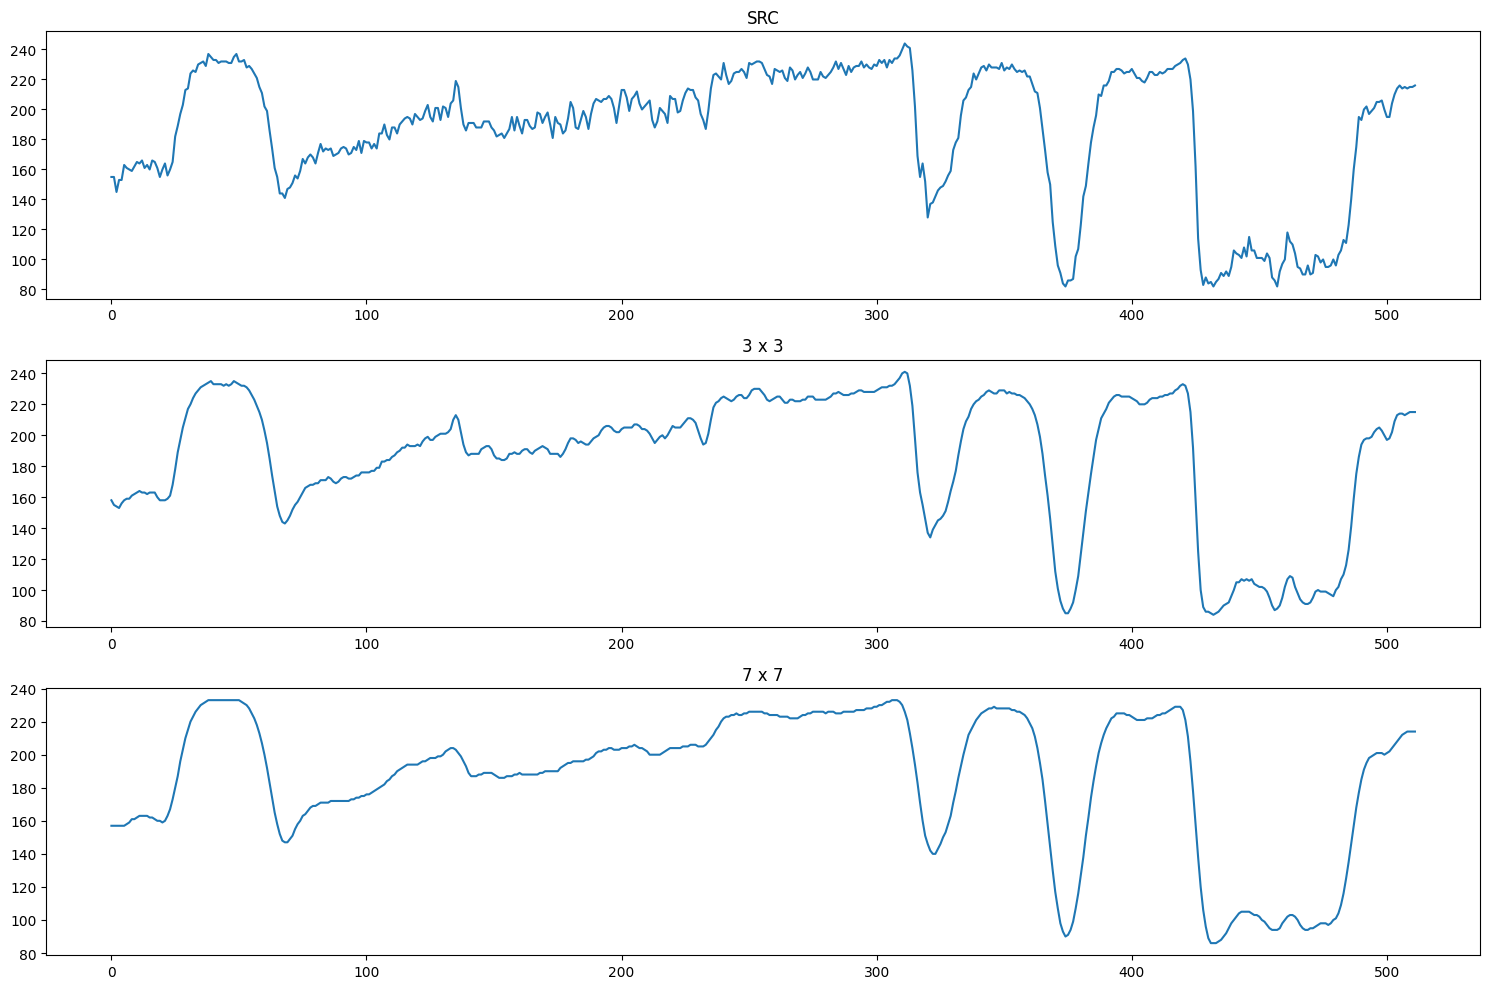

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.plot(img[:, :, 2][100])  # red
plt.title("SRC")

plt.subplot(3, 1, 2)
plt.plot(img_blur1[:, :, 2][100])
plt.title("3 x 3")

plt.subplot(3, 1, 3)
plt.plot(img_blur2[:, :, 2][100])
plt.title("7 x 7")

plt.tight_layout()
plt.show()

### Gaussian Blur

- 대상 픽셀(Anchor)와 가까운 픽셀은 큰 가중치 멀리있는 픽셀은 작은 가중치를 사용해서 평균(가중평균)을 계산해서 필터링 한다.
    - Gaussian 분포(정규분포)의 확률밀도 함수를 사용해 필터에 들어갈 값들을 계산하여 대상픽셀을 기준으로 멀어질 수록 작은 값이 곱해지도록 한다. 
    - 평균은 0으로 하고 표준편차를 조정하여 흐림의 정도를 조절한다. 표준편차 값을 크게할 수록 흐려진다.
    - Filter의 shape은 $(8\sigma + 1,\;8\sigma + 1)$ 나 $(6\sigma + 1,\;6\sigma + 1)$ 으로 정해진다. $\sigma: 표준편차$
- Gaussian Blurring은 blur효과 뿐아니라 노이즈제거에도 많이 사용된다.

![image-2.png](figures/gaussianblur_filter.png)

- **GaussianBlur Filter의 형태**
 
![image.png](figures/gaussianblur_filter2.png)

- **`cv2.GaussianBlur(src, ksize, sigmaX, sigmaY)`**
    - src: blur를 적용할 영상. 
    - ksize: 커널크기. (0,0)으로 지정하면 sigma 값에 의해 결정된다. (보통 0,0 으로 설정)
    - sigamX: X축방향 sigma(표준편차) 값
    - sigamY: Y축방향 sigma(표준편차) 값. 생략하면 sigmaX와 같은 값 사용


In [14]:
img = cv2.imread("images/lenna.bmp")
img_1 = cv2.GaussianBlur(img, (0, 0), # filter(kernel) size = (0, 0) => 표준편차를 이용해서 size를 결정 하는 경우.
                                 sigmaX=1, # x축(좌우방향) 표준편차. 클 수록 filter크기도 커짐.
                                                # sigmaY (상하 방향) 표준편차. 생략-sigmaX값을 사용.
                                  )
img_2 = cv2.GaussianBlur(img, (0, 0), sigmaX=2)
img_5 = cv2.GaussianBlur(img, (0, 0), sigmaX=5)


cv2.imshow("src", img)
cv2.imshow("sigma 1", img_1)
cv2.imshow("sigma 2", img_2)
cv2.imshow("sigma 5", img_5)

cv2.waitKey()
cv2.destroyAllWindows()

### 잡음 제거
- `cv2.bilateralFilter(src, d, sigmaColor, sigmaSpace)`
    - 양방향 필터로 선명도는 유지하면서 bluring을 이용해 노이즈를 제거한다.
    - src: 잡음을 제거할 입력영상
    - d: 필터의 크기 지정(가우시안 blur의 ksize). 음수(-1)을 입력하면 sigmaSpace값에 의해 자동 결정된다. 일반적으로 -1을 설정한다.
    - sigmaColor
        - 엣지인지 아닌지를 판단하는 기준값 설정. pixcel간의 차이가 지정한 값보다 크면 엣지라고 생각하고 작으면 엣지가 아니라고 생각해 그 지점을 blurring 한다.
        - 이 값을 너무 크게 주면 엣지가 검출이 안되서 그냥 Gaussian Filter 사용하는 것과 같다.
    - sigmaSpace: Gaussian Filter에서 지정한 표준편차

In [24]:
img = cv2.imread("images/lenna.bmp")
result = cv2.bilateralFilter(
    img,            # 대상이미지
    d=-1,          # 필터 크기. sigmaSpace(가우시안필터의 표준편차) 로 크기를 지정. => -1
    sigmaColor=50, # 평균값 계산할 때 포함시킬지 여부를 판단하는 기준값. 
                         # anchor 픽셀값과 지정한 값(50)이내로 차이나는 것만 계산시 적용.
    sigmaSpace=5, # 가우시안필터 표준편차.
)

cv2.imshow("src", img)
cv2.imshow("result", result)
cv2.waitKey()
cv2.destroyAllWindows()

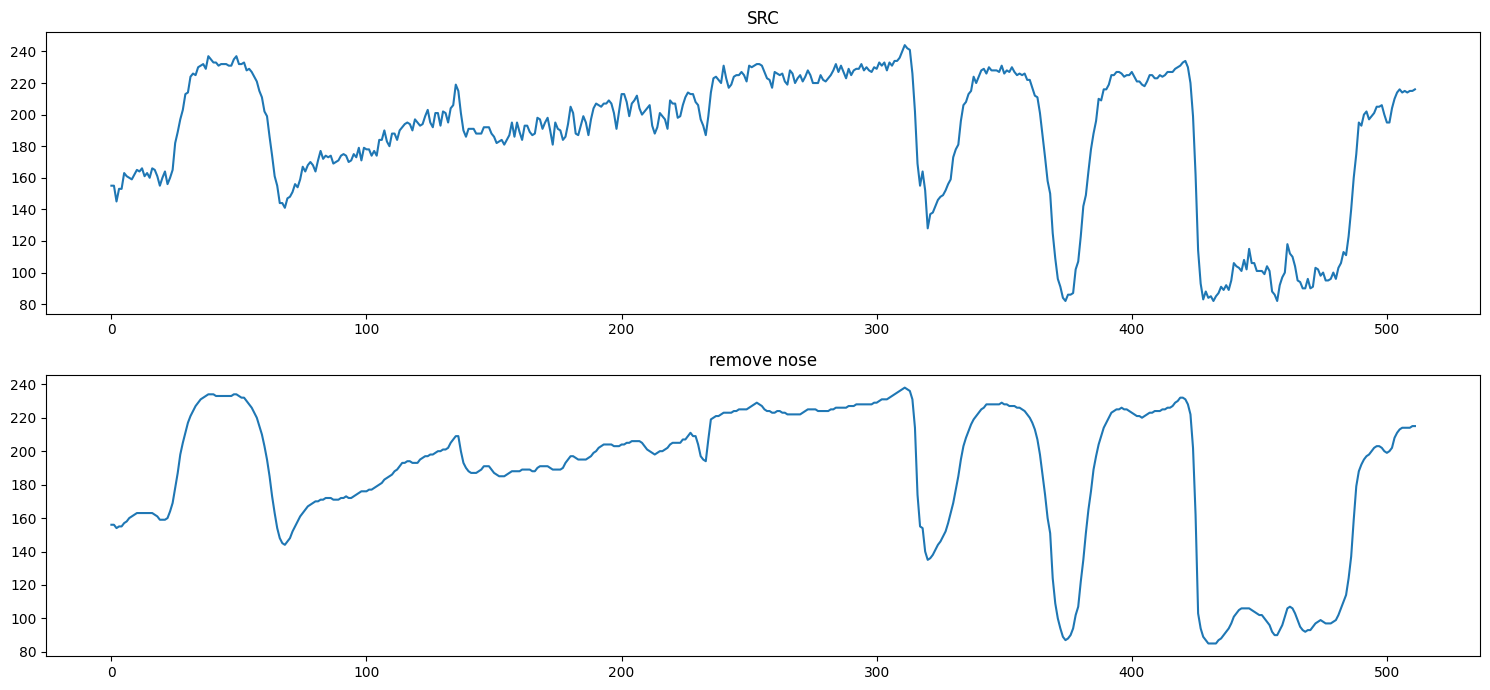

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.subplot(2, 1, 1)
plt.plot(img[:, :, 2][100])  # red
plt.title("SRC")

plt.subplot(2, 1, 2)
plt.plot(result[:, :, 2][100])
plt.title("remove nose")

plt.tight_layout()
plt.show()

# 엣지검출 (Edge Detection)

- 엣지(edge)
    - 배경과 물체 또는 물체와 물체간의 경계를 말한다.
- 엣지 검출
    - 엣지는 경계가 되는 부분으로 픽셀값이 급격하게 변하게 되므로 그 변화되는 픽셀들을 찾아낸다.
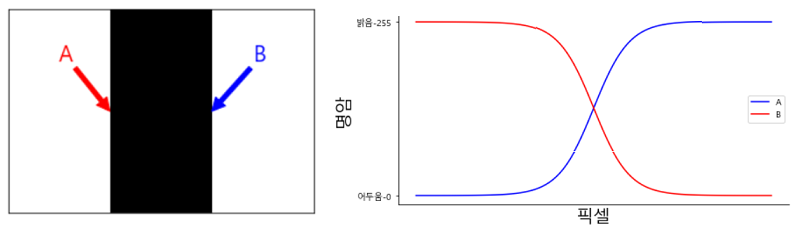
   
   - 엣지 검출을 통해 물체들의 윤곽만 남기고 필요없는 물체나 배경은 제거할 수 있다.
   - Edge detection은 noise의 영향을 많이 받아 일반적으로 blur를 수행 한 후에 Edge detection을 수행
       - edge와 noise는 픽셀 단위로 보면 주변 픽셀과 값의 차이가 많이 난다는 점에서 비슷한 성격을 가지고 있다.
       - 값의 차이가 많이나는 픽셀들이 연결되어 있으면 edge고 연결이 안되있으면 noise이다.

### 엣지 검출과 미분
- 픽셀값의 차이가 큰 부분을 엣지로 판단 하므로 연속된 픽셀값에 미분을 해서 찾아낸다.  
- 그러나 영상의 픽셀값들은 특정 함수에 의해 구해진 값들이 아니어 도함수를 구할 수 없으므로 미분 근사값을 이용해 구해야 한다.

#### 1차 미분의 근사화
- 전진 차분(Forward difference)
    - $\cfrac{\partial{f}}{\partial{x}}\;\cong\;\cfrac{f(x+h) - f(x)}{h}$
- 후진 차분(Backward difference)
    - $\cfrac{\partial{f}}{\partial{x}}\;\cong\;\cfrac{f(x) - f(x-h)}{h}$
- 중앙 차분(Centered difference)
    - $\cfrac{\partial{f}}{\partial{x}}\;\cong\;\cfrac{f(x+h) - f(x-h)}{2h}$
- 엣지 검출은 **중앙 차분 연산**을 사용(응용)한다. h(X의 변화)는 현재 픽셀(x)에서 얼마나 떨어진 pixcel인 지를 의미한다. 우리는 현재 픽셀과 이전, 이후 픽셀간의 차이(변화율)을 보는 것이 목적이므로 h를 1로 설정한다. 엣지 검출에서는 픽셀간의 변화율을 보는 것이 목적이므로 1/2로 곱하는 것은 하지 않는다.
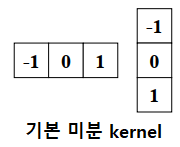

- 주요 미분 커널
  
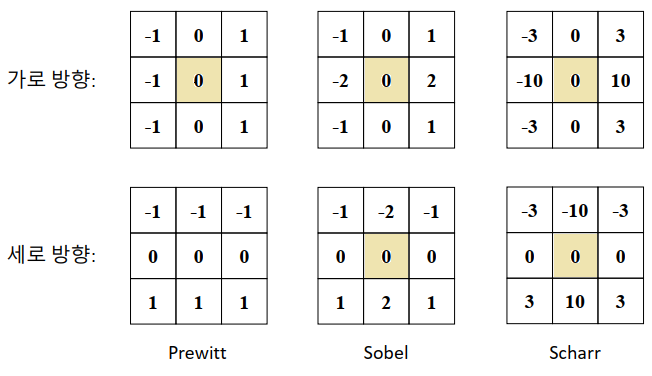

#### 소벨 필터 직접 만들어서 적용

- `cv2.filter2D(src, ddepth, kernel, dst=None, anchor=None, delta=None, borderType=None)`
    - 입력이미지와 필터의 convolution 연산처리를 해주는 함수
    - src: 입력영상
    - ddepth: 출력 영상데이터의 타입 (opencv제공 변수 사용. cv2.CV_8U, cv2.CV_32F), -1 지정하면 입력영상과 같은 타입의 결과를 출력
    - kernel: Filtering을 수행할 kernel 행렬. (실수형)
    - anchor: kernel의 achor 위치. (-1,-1) 지정하면 kernel의 중앙을 사용
    - delta: 추가적으로 더할값. 
    - borderType: padding 타입
    - 반환값
        - Filtering된 결과영상

In [38]:
# 엣지 검출 -> grayscale 영상을 이용.
# img = cv2.imread("images/sudoku.webp", cv2.IMREAD_GRAYSCALE)
img = cv2.imread("images/lenna.bmp", cv2.IMREAD_GRAYSCALE)
kernel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

kernel_y = np.array([
    [-1, -2, -1],
    [0,   0,  0],
    [1,   2,  1]
])
x_edge = cv2.filter2D(img, -1, kernel_x)  #img에 대해서 kernel_x를 이용해 convolution 연산
y_edge = cv2.filter2D(img, -1, kernel_y)
edge = x_edge + y_edge

cv2.imshow("src", img)
cv2.imshow("x_edge", x_edge)
cv2.imshow("y_edge", y_edge)
cv2.imshow("edge", edge)

cv2.waitKey()
cv2.destroyAllWindows()

### sobel 함수 이용
- **`cv2.Sobel(src, ddepth, dx, dy, ksize, scale, delta)`**
    - src: 엣지를 검출할 영상
    - ddepth: 출력 영상의 타입. -1로 지정하면 입력영상과 같은 타입 사용.
    - dx, dy: x/y 방향 미분의 차수
        - dx=1, dy=0 : 가로방향
        - dx=0, dy=1 : 세로방향
    - ksize: 커널의 크기. 보통 3으로 준다.
    - scale: 연산결과에 추가적으로 곱할값. Default: 1
    - delta: 연산결과에 추가적으로 더할값. Default: 0
- **`cv2.magnitude(x, y)`**
    - x방향, y방향 값을 방향을 고려해서 합치는 함수
    - x: x방향 값
    - y: y방향 값    

### 가로/세로방향 엣지검출 합치기

In [46]:
img = cv2.imread("images/sudoku.webp", cv2.IMREAD_GRAYSCALE)

sb_x = cv2.Sobel(img, -1, 1, 0, ksize=3)
sb_y = cv2.Sobel(img, -1, 0, 1, ksize=3)

sb_edge1 = cv2.add(sb_x, sb_y)
sb_edge2 = cv2.magnitude(sb_x.astype('float64'), sb_y.astype('float64'))
sb_edge2 = sb_edge2.astype('uint8')

cv2.imshow("src", img)
cv2.imshow("sb_x", sb_x)
cv2.imshow("sb_y", sb_y)
cv2.imshow("sb_edge1", sb_edge1)
cv2.imshow("sb_edge2", sb_edge2)

cv2.waitKey()
cv2.destroyAllWindows()

### Canny
- Noise에 강한 edge detection 알고리즘.
- 단계
    1. Gaussian blur를 수행해 noise를 제거
    2. Sobel Filter를 이용해 x, y축으로 gradient 계산
    3. x, y축 gradient 합치기
    4. Non-Maximum Suppession(NMS) 수행해서 엣지가 두꺼워지는 것을 방지
        - 주위(local)에서 가장 큰 값들만 남긴다.
    5. Doubling thresholding
        - low threshold, high threshold를 기준으로 값들 제거
        - low threshold 이하의 값들 제거
        - low와 high threshold 사이의 값들은 high threshold와 연결된 것만 남기고 연결 안된것은 제거
            - 약한 edge
        - high threshold 이상의 값들은 유지
            - 강한 edge
        
     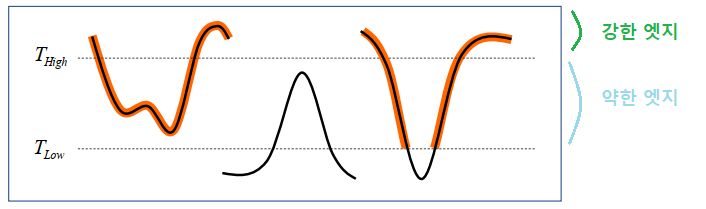

- `cv2.Canny(image, threshold1, threshold2)`
    - image: Canny 엣지 검출을 할 원본 이미지
    - threshold1: low threshold
    - threshold2: high threshold
        - threshold1과 threshold2 는 1:2 또는 1:3 정도 비율로 준다.

In [48]:
img = cv2.imread("images/lenna.bmp", cv2.IMREAD_GRAYSCALE)
img_canny = cv2.Canny(img, 50, 150)

cv2.imshow('src', img)
cv2.imshow("canny", img_canny)
cv2.waitKey()
cv2.destroyAllWindows()

### 모폴로지(Morphology) 이미지 전처리 기법

- 영상분야에서 물체의 형태에 대해 분석하고 처리하는 기법으로 노이즈 제거나 영역 간 경계를 변형하는 등의 이미지 전처리에 사용된다.
- 이진 영상에 적용할 수 있다.
> - 모폴로지는 생물의 구조나 외형을 연구하는 학문을 말한다.

#### 주요기능
- **침식(Erosion)**
    - 물체의 외곽을 깍아내는 효과가 있어서 침식이라고 한다.
    - 0, 1로 구성된 커널을 이동시키면서 kernel이 위치한 부분의 화소가 모두 255가 아니면 커널의 anchor와 맞닿은 pixel의 값을 0으로 변환한다.
    - 어두운 부분에 있는 노이즈 (주위가 0인데 255가 노이즈로 있는 경우)를 제거하는데 효과가 있다.
    - `cv2.erode(src, kernel, dst=None, anchor=None, iterations=None, borderType=None, borderValue=None)`
        - src : 입력 영상
        - kernel : kernel 행렬 (`cv2.getStructuringElement()` 이용해 생성)
        - anchor: anchor점 위치 (기본: 중앙점)    
&nbsp;&nbsp;&nbsp;<img src="figures/erosion.png" width="800">

> - kernel 생성 함수
> - `cv2.getStructuringElement(shape, ksize, anchor)`
>     - shape: kernel `1` 의 위치
>         - cv2.MORPH_RECT: 사각형
>         - cv2.MORPH_CROSS: 십자가
>         - cv2.MORPH_ELLIPSE: 사각형에 내접하는 타원
>     - ksize: 크기 지정. (width, height)
>     - anchor: 고정점(anchor) 위치. (-1, -1)을 지정하면 중앙점이 anchor가 된다.

In [27]:
# filter 확인
cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5), (-1, -1))
# cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5), (-1, -1))
# cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5), (-1, -1))

array([[0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [29]:
img = cv2.imread("images/lenna.bmp", cv2.IMREAD_GRAYSCALE)
# 모폴로지 -> 이진화 영상(0, 255구성) 으로 처리.
_, img_bin = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
#  img의 픽셀값들중 127 미만은 0으로 127이상은 255로 변환.
# (threshold값,  변환된 이미지)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3), anchor=(-1,-1))

# 침식
img_erode = cv2.erode(img_bin, kernel=kernel)

In [30]:
cv2.imshow("src", img)
cv2.imshow("binary", img_bin)
cv2.imshow("erode", img_erode)

cv2.waitKey()
cv2.destroyAllWindows()

- 팽창(Dilation)
    - 외곽을 확대하는 효과가 있어 팽창이라고 한다.
    - 침식과 반대로 kernel과 한 pixcel이라도 만날 경우 anchor의 pixcel값을 255로 변경한다.
    - 밝은 부분의 노이즈(주위가 255인데 0인 노이즈가 있는 경우 )를 제거하는데 효과가 있다.
    - `cv2.dilate(src, kernel, dst=None, anchor=None, iterations=None, borderType=None, borderValue=None)`
        - src : 입력 영상
        - kernel : kernel 행렬 (`cv2.getStructuringElement()` 이용해 생성)
        - anchor: anchor점 위치 (기본: 중앙점)    
      
&nbsp;&nbsp;&nbsp;<img src='figures/dilation.png' width="800">

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3), (-1, -1))
img_dilate = cv2.dilate(img_bin, kernel)   # 대상: 이진화된 source

cv2.imshow("src", img_bin)
cv2.imshow("dilate", img_dilate)
cv2.waitKey()
cv2.destroyAllWindows()

- **열림(Open)**
    - 침식을 한 후에 팽창을 한다.
    - 주변보다 밝은 노이즈(255)를 제거하거나 돌출된 픽셀을 제거하는데 효과적이다.
- **닫힘(Close)**
    - 열림과 반대로 팽창을 한 후에 침식을 수행한다.
    - 주변보다 어두운 노이즈(0)을 제거하는데 효과적이며 끊어져 보이는 object를 연결하거나 구멍을 메우는데 효과적이다.
- **그래디언트(Gradient)**
    - 팽창을 적용한 결과에서 침식을 적용한 결과를 뺀 처리를 한다. 그러면 **경계선(edge)** 을 얻게 되어 엣지 검출의 효과를 얻을 수있다.
        - $팽창 - 침식$
- **탑햇(Tophat)**
    - **Tophat과 Balckhat 연산은 밝기 값이 크게 변하는 영역을 강조한다.**
    -  원본영상에서 열림 처리한 결과를 뺀 처리를 한다. 이 결과 **밝은 영역을 강조** 할 수있다.
-  **블랙햇(Blackhat)**
    -  닫힘 연산을 적용한 결과에서 원본을 뺀 처리를 한다. 이 결과 **어두운 부분을 강조** 할 수있다.
- 위의 연산처리는 `cv2.morphologyEx()` 함수를 사용한다.

- `cv2.morphologyEx(src, op, kernel, dst=None, anchor=None, iterations=None, borderType=None, borderValue=None)`
    - src : 입력 영상(원본 이미지)
    - op : 모폴로지 연산 플래그
    - kernel : 커널 행렬
    
|op|설명|효과|
|:-|:-:|-:|
|cv2.MORPH_ERODE|침식|어두운 영역 노이즈 제거|
|cv2.MORPH_DILATE|팽창|밝은 영역 노이즈 제거|
|cv2.MORPH_OPEN|열기|외곽 제거|
|cv2.MORPH_CLOSE|닫기|내부 채우기|
|cv2.MORPH_GRADIENT|그래디언트|팽창 - 침식|
|cv2.MORPH_TOPHAT|탑햇|원본 - 열림|
|cv2.MORPH_BLACKHAT|블랙햇|닫힘 - 원본|

In [31]:
img_open = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel)
img_close = cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, kernel)
img_grad = cv2.morphologyEx(img_bin, cv2.MORPH_GRADIENT, kernel)
img_tophat = cv2.morphologyEx(img_bin, cv2.MORPH_TOPHAT, kernel)
img_blackhat = cv2.morphologyEx(img_bin, cv2.MORPH_BLACKHAT, kernel)

In [33]:
cv2.imshow("img", img)
cv2.imshow("img_bin", img_bin)
cv2.imshow("open", img_open)
cv2.imshow("close", img_close)
cv2.imshow("gradient", img_grad)
cv2.imshow("tophat", img_tophat)
cv2.imshow("blackhat", img_blackhat)
cv2.waitKey()
cv2.destroyAllWindows()